In [15]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import os
import investpy as df
import investpy
import json
import csv
import operator
from matplotlib import dates
import datetime
from sqlalchemy.orm import Session
%matplotlib inline

In [16]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

#for normalizing data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

#read the file
df_Appl = pd.read_csv('AAPL Historical Data.csv')
df_Amzn = pd.read_csv('AMZN Historical Data.csv')

#print the head
df_Appl.head()
#df_Amzn.head()

,Date,Price,Open,High,Low,Volume,Change %
0,2020-11-13,119.26,119.44,119.67,117.87,81.69M,0.0004
1,2020-11-12,119.21,119.55,120.52,118.58,103.35M,-0.0023
2,2020-11-11,119.49,117.17,119.59,116.51,112.29M,0.0304
3,2020-11-10,115.97,115.57,117.58,114.14,138.02M,-0.0030
4,2020-11-09,116.32,120.50,121.98,116.12,154.52M,-0.0200


In [17]:
#setting index as date
df_Amzn['Date'] = pd.to_datetime(df_Amzn.Date,format='%Y-%m-%d')
df_Amzn.index = df_Amzn['Date']

In [55]:
df_Appl['Date'] = pd.to_datetime(df_Appl.Date,format='%Y-%m-%d')
df_Appl.index = df_Appl['Date']

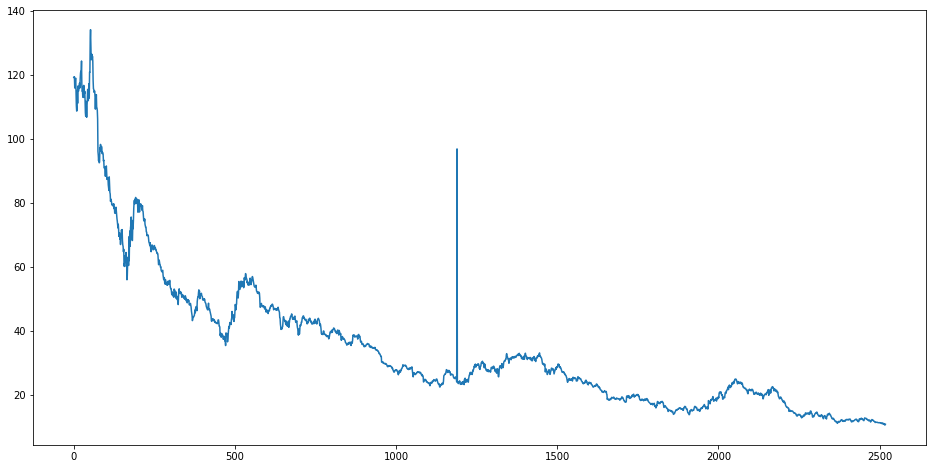

In [18]:
#plot
plt.figure(figsize=(16,8))
plt.plot(df_Appl['Price'], label='Close Price history')

In [19]:
#creating dataframe with date and the target variable
data = df_Appl.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_Appl)),columns=['Date', 'Price'])

In [20]:
for i in range(0,len(data)):
     new_data['Date'][i] = data['Date'][i]
     new_data['Price'][i] = data['Price'][i]

In [21]:
# splitting into train and validation
train = new_data[:2000]
valid = new_data[2000:]

In [22]:
# shapes of training set
print('\n Shape of training set:')
print(train.shape)


 Shape of training set:
(2000, 2)


In [23]:
# shapes of validation set
print('\n Shape of validation set:')
print(valid.shape)


 Shape of validation set:
(519, 2)


In [48]:
# In the next step, we will create predictions for the validation set and check the RMSE using the actual values.
# making predictions
preds = []
for i in range(0,valid.shape[0]):
    a = train['Price'][len(train)-248+i:].sum() + sum(preds)
    b = a/248
    preds.append(b)

In [49]:
# checking the results (RMSE value)
rms=np.sqrt(np.mean(np.power((np.array(valid['Price'])-preds),2)))
print('\n RMSE value on validation set:')
print(rms)


 RMSE value on validation set:
14.770764153196163


C:\Users\jhoff\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\jhoff\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


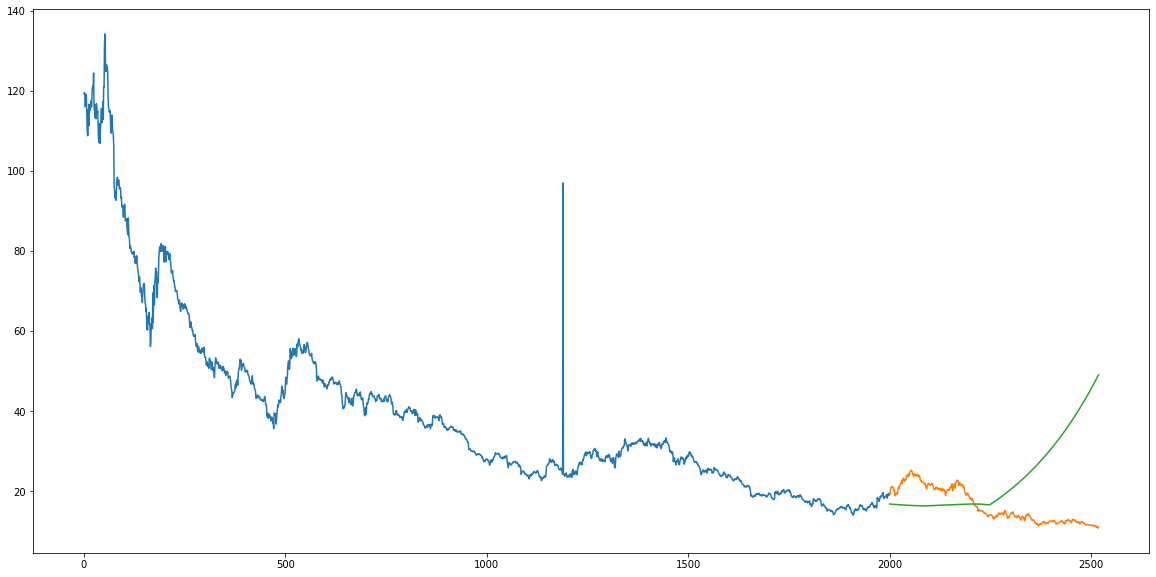

In [50]:
#plot
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Price'])
plt.plot(valid[['Price', 'Predictions']])

# K Nearest Neighbors

In [85]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df_Appl.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df_Appl)),columns=['Date', 'Price'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Price'][i] = data['Price'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:987,:]
valid = dataset[987:,:]

#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

Using TensorFlow backend.
C:\Users\jhoff\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jhoff\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jhoff\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jhoff\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py


Epoch 1/1
 - 33s - loss: 1.0585e-04


In [86]:
#scaling data
x_train_scaled = scaler.fit_transform(x_train)
x_train = pd.DataFrame(x_train_scaled)
x_valid_scaled = scaler.fit_transform(x_valid)
x_valid = pd.DataFrame(x_valid_scaled)

#using gridsearch to find the best parameter
params = {'n_neighbors':[2,3,4,5,6,7,8,9]}
knn = neighbors.KNeighborsRegressor()
model = GridSearchCV(knn, params, cv=5)

#fit the model and make predictions
model.fit(x_train,y_train)
preds = model.predict(x_valid)

ValueError: Found array with dim 3. MinMaxScaler expected <= 2.

# Linear Regression

In [80]:
#setting index as date values
df_Appl['Date'] = pd.to_datetime(df_Appl.Date,format='%Y-%m-%d')
df_Appl.index = df_Appl['Date']

In [81]:
#sorting
data = df_Appl.sort_index(ascending=True, axis=0)

#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df_Appl)),columns=['Date', 'Price'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Price'][i] = data['Price'][i]

In [82]:
#split into train and validation
train = new_data[:987]
valid = new_data[987:]

x_train = train.drop('Price', axis=1)
y_train = train['Price']
x_valid = valid.drop('Price', axis=1)
y_valid = valid['Price']

#implement linear regression
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)

TypeError: float() argument must be a string or a number, not 'Timestamp'

In [51]:
pip install fastai

  Using cached fastai-2.1.5-py3-none-any.whl (188 kB)
Note: you may need to restart the kernel to use updated packages.


In [68]:
!python -m pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to c:\users\jhoff\appdata\local\temp\pip-req-build-3c65ycav
  Created wheel for fastai: filename=fastai-2.1.6-py3-none-any.whl size=190058 sha256=1fe8690c13f6d4b9b49c617ea1264ae8ab7c459f9147b3753eb92891c75fe870
  Stored in directory: C:\Users\jhoff\AppData\Local\Temp\pip-ephem-wheel-cache-fgwuvg_w\wheels\e2\81\30\9d0af3c5b8212ceb1118de039a8973c37f047102062f346d19
Successfully built fastai
  Attempting uninstall: fastai
    Found existing installation: fastai 2.1.5
    Uninstalling fastai-2.1.5:
      Successfully uninstalled fastai-2.1.5


  Running command git clone -q https://github.com/fastai/fastai.git 'C:\Users\jhoff\AppData\Local\Temp\pip-req-build-3c65ycav'


In [87]:
#create features
from fastai.tabular import add_datepart
add_datepart(new_data, 'Date')
new_data.drop('Elapsed', axis=1, inplace=True)  #elapsed will be the time stamp

ImportError: cannot import name 'add_datepart' from 'fastai.tabular' (C:\Users\jhoff\anaconda3\lib\site-packages\fastai\tabular\__init__.py)

In [62]:
df_Appl = add_datepart(df_Appl, 'date')

NameError: name 'add_datepart' is not defined